<a href="https://colab.research.google.com/github/DCI-alxogm/ml2023-proditorIF/blob/main/oct6-7/emce_7_10_23_McL_BRM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [90]:
#Se importan las librerias necesarias
from numpy.linalg import linalg
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.preprocessing import StandardScaler #Normaliza los datos
import emcee
import corner

In [1]:
drive.mount('/content/drive')
file ="/content/drive/MyDrive/Machine_Learn/olympic100m_men.txt"
data=np.loadtxt(file,delimiter=",").T

Mounted at /content/drive


In [11]:
#Se realizan las instalaciones de los paquetes necesarios
!python -m pip install corner
!pip install -U setuptools setuptools_scm pep517
!pip install -U emcee

Text(0, 0.5, 'Velocidad')

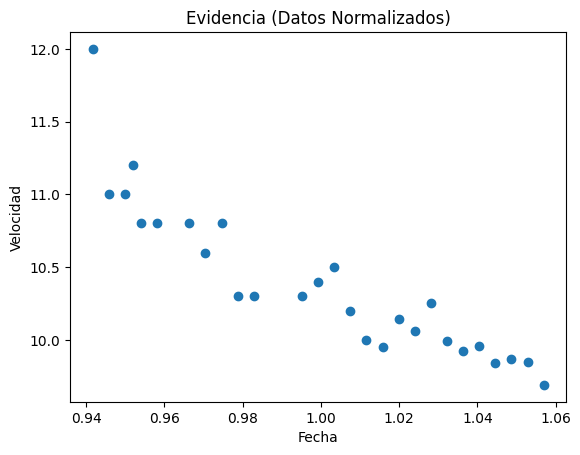

In [60]:
#Asigamos los datos
dataN = (data-np.mean(data))/np.std(data)
x=dataN[0]
y=data[1]
plt.plot(x,y,'o')
plt.title("Evidencia (Datos Normalizados)")
plt.xlabel("Fecha")
plt.ylabel("Velocidad")

#### Aplicamos mínimos cuadrados para obtener valores inciales

Parámetros inciales
b =23.33379128347669
 m =-12.948368137147472


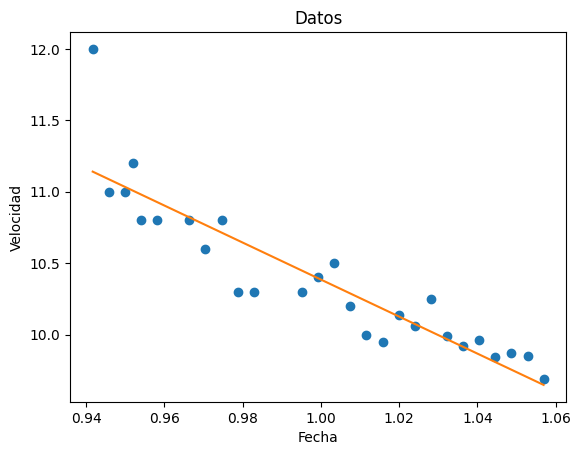

In [61]:
def Wpoly(x, y, n):
     X=np.vstack([np.ones_like(x)]) #matriz
     for i in range(1,n+1):
      Xa=np.vstack([x**i])
      X=np.concatenate([X, Xa])
      Xm=np.matmul(X,X.T) #X^T*X
      invx =np.linalg.inv(Xm)
      Xt =np.matmul(X,y) #X^T*t
      W=np.matmul(invx,Xt)#Se calcula W
     return W
minC = Wpoly(x,y,1)
x0 = np.linspace(min(x), max(x), 27)
Ym = minC[0]+x0*minC[1]
plt.plot(x,y,'o',label="Dispersión ")
plt.plot(x0,Ym,label='Mínimos cuadrados ')
plt.title("Datos")
plt.xlabel("Fecha")
plt.ylabel("Velocidad")
print(f"Parámetros inciales\nb ={minC[0]}\n m ={minC[1]}")

#### Aplicación de emcee

In [77]:
#Se asigan los parámetros inciales
N = len(x)
b_true = minC[0]
m_true = minC[1]
i = np.random.randint(N)
f_true = Ym[i]
yerr = 0.1 + 0.5 * np.random.rand(N) #Error aleatorio en Y

In [66]:
def log_likelihood(theta, x, y, yerr):
    m, b, log_f = theta
    model = m * x + b
    sigma2 = yerr**2 + model**2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

Maximum likelihood estimates:
m = -11.971
b = 22.338
f = 0.010


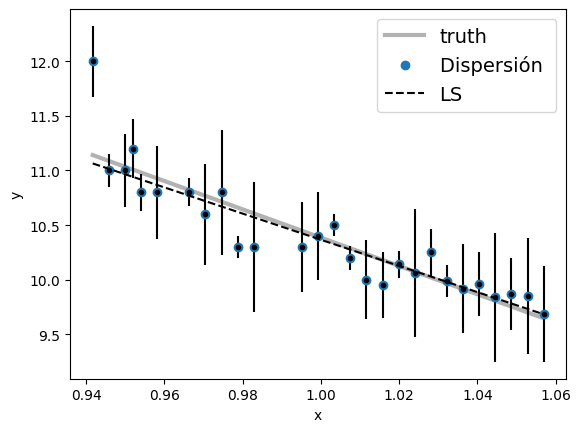

In [78]:
np.random.seed(42)
nll = lambda *args: -log_likelihood(*args)
initial = np.array([m_true, b_true, np.log(f_true)]) + 0.1 * np.random.randn(3)
soln = minimize(nll, initial, args=(x, y, yerr))
m_ml, b_ml, log_f_ml = soln.x

print("Maximum likelihood estimates:")
print("m = {0:.3f}".format(m_ml))
print("b = {0:.3f}".format(b_ml))
print("f = {0:.3f}".format(np.exp(log_f_ml)))
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3, label="truth")
plt.plot(x,y,'o',label="Dispersión ")
plt.plot(x0, b_ml+x0*m_ml, "--k", label="LS")
plt.legend(fontsize=14)
plt.xlabel("x")
plt.ylabel("y");

In [79]:
def log_prior(theta):
    m, b, log_f = theta
    if -5.0 < m < 0.5 and 0.0 < b < 10.0 and -10.0 < log_f < 1.0:
        return 0.0
    return -np.inf
def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

In [100]:
pos = soln.x + 1e-4 * np.random.randn(25, 3)
nwalkers, ndim = pos.shape
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(x, y, yerr)
)
sampler.run_mcmc(pos, 5000, progress=True);

100%|██████████| 5000/5000 [00:05<00:00, 902.42it/s] 


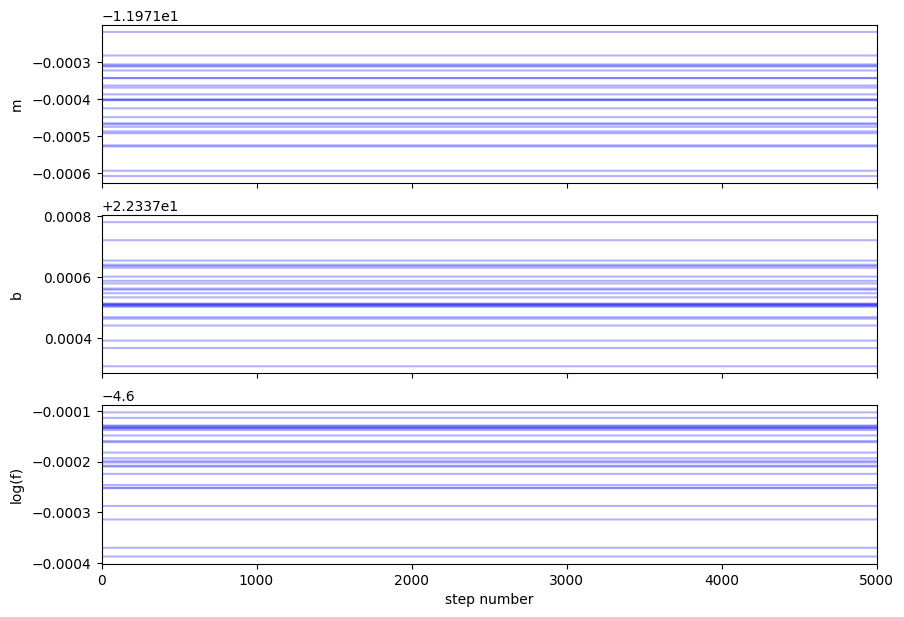

In [101]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["m", "b", "log(f)"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "b", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [102]:
tau = sampler.get_autocorr_time()
print(tau)
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

[nan nan nan]
(8150, 3)


/usr/local/lib/python3.10/dist-packages/emcee/autocorr.py:38: RuntimeWarning: invalid value encountered in divide
  acf /= acf[0]


Resultados

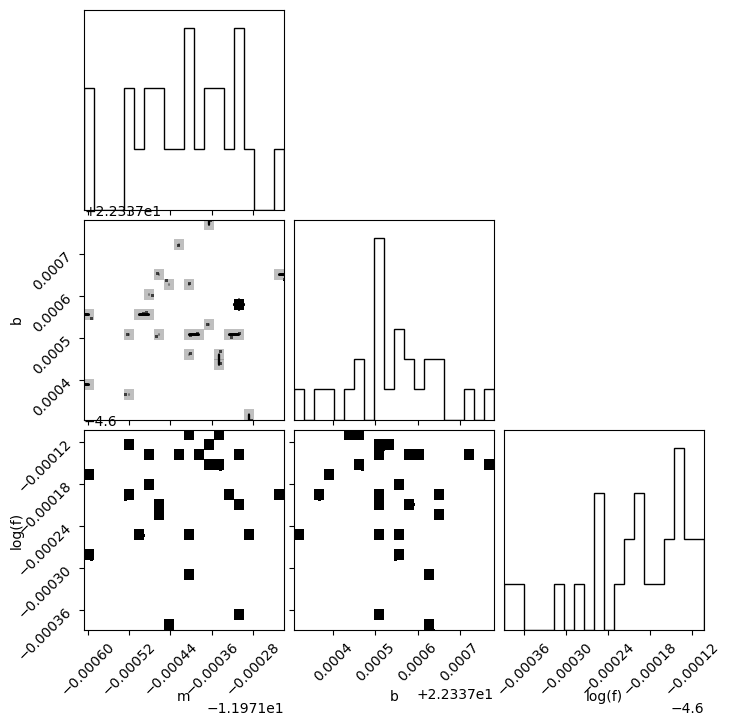

In [103]:
fig = corner.corner(
    flat_samples, labels=labels, truths=[m_true, b_true, np.log(f_true)]
);